# Использование  pre-trained моделей

У нас мало данных, слабые машины, но задачу решать нужно. Что же мы можем сделать? Правильно-взять какую-то предобученную для похожей задачи модель, немного покрутить ее и использовать для нашей задачи!


## Feature extraction

Когда мы обучаем сверточные сети, то свертки пытаются найти патерны в данных и мы можем пытаться взять эту информацию из уже обученных сетей. Делается это примерно следующим образом

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

Почему не использовать и полносвязные слои для такого подхода? Полносвязные слои по своей архитектуре учат слишком мелкие зависимости и могут использоваться только для изначальной задачи. Можно, конечно, попробавть использовать и переобучать и их, но значительно сложнее.


Мы возьмем модельку VGG16. В керасе уже лежат часть моделей из ImageNet победитель.

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet


In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

We passed three arguments to the constructor:

* `weights`, на каком датасете обучалась нейронная сеть
* `include_top`, Включать ли итоговый полносвязный слой, который и выдавал вероятность угадывания класса картинки.
* `input_shape`, Входящий слой, какая размерность нашей итоговой картинки.


In [2]:
# посмотрим на нашего монстра
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
# загрузка данных
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline


datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Мы должны остановится, если подали хоть раз экземляр
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Последний слой мы должны скормить полносвязнному слою и наши картинки тоже должны быть в определенном формате. Воспользуемся этим.

In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [1]:
# обучаем модель 
# а какую - ну это уже на ваш вкус и цвет

Обучаемся очень быстро. Посмотрим,что там у нас получилось.

In [3]:

# Ну и можем глянуть, какое качетсво мы получим


Также мы можем попробовать дообучить нашу модель, собрав одну большу модель.
### Вперед!

In [8]:
#### ВАШ КОД ####

должно получится что-то такое.

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Очень много параметров нам надо оценить. Хотим ли мы их учить все и сразу?


У нас осталось только несколько тренировочных параметров. Также добавим data aurgementation и посмотрим, что получится.

In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 16s - loss: 0.6018 - acc: 0.6800 - val_loss: 0.4729 - val_acc: 0.7830
Epoch 2/30
 - 15s - loss: 0.4882 - acc: 0.7850 - val_loss: 0.3711 - val_acc: 0.8650
Epoch 3/30
 - 15s - loss: 0.4429 - acc: 0.8080 - val_loss: 0.3418 - val_acc: 0.8670
Epoch 4/30
 - 15s - loss: 0.4002 - acc: 0.8255 - val_loss: 0.3039 - val_acc: 0.8820
Epoch 5/30
 - 15s - loss: 0.3747 - acc: 0.8435 - val_loss: 0.2914 - val_acc: 0.8850
Epoch 6/30
 - 15s - loss: 0.3638 - acc: 0.8375 - val_loss: 0.2800 - val_acc: 0.8860
Epoch 7/30
 - 15s - loss: 0.3594 - acc: 0.8390 - val_loss: 0.2745 - val_acc: 0.8870
Epoch 8/30
 - 15s - loss: 0.3423 - acc: 0.8540 - val_loss: 0.2692 - val_acc: 0.8900
Epoch 9/30
 - 15s - loss: 0.3428 - acc: 0.8465 - val_loss: 0.2703 - val_acc: 0.8860
Epoch 10/30
 - 15s - loss: 0.3370 - acc: 0.8595 - val_loss: 0.2599 - val_acc: 0.8910
Epoch 11/30
 - 15s - loss: 0.3375 - acc: 0.8490 - val_loss: 0.2558 - val_ac

In [14]:
model.save('cats_and_dogs_small_3.h5')

Нарисуем полученные результаты

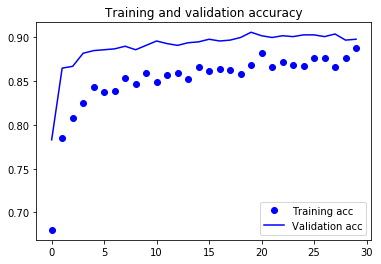

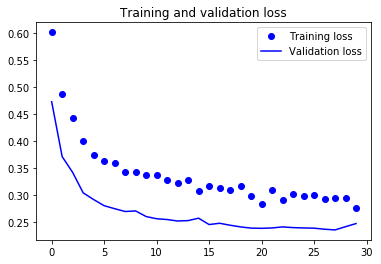

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Точность на валидации 90%, уже совсем неплохо.

## Fine-tuning

Также мы можем морозить только определенные слои, блоки. Что может быть удобным

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

Вспомним, структуру модели VGG16

In [17]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________


Почему мы отключаем последнии слои? чем сложнее модель, чем глубже слой, тем более сложные фичи она использует, и более обучается под специфичные данные. Также все упирается в данные и мошности, если мощностей нет или недостаточно данных, чем меньше мы параметров обучаем, тем нам лучше. Наверное стоит заморозить не все, а только часть весов. 

#### Сможете?

Какой learning_rate мы должны делать в таком случае?

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 16s 165ms/step - loss: 0.2785 - acc: 0.8785 - val_loss: 0.2354 - val_acc: 0.9130
Epoch 2/100
100/100 [==============================] - 15s 152ms/step - loss: 0.2562 - acc: 0.8990 - val_loss: 0.2128 - val_acc: 0.9160
Epoch 3/100
100/100 [==============================] - 15s 152ms/step - loss: 0.2409 - acc: 0.8970 - val_loss: 0.2103 - val_acc: 0.9190
Epoch 4/100
100/100 [==============================] - 15s 153ms/step - loss: 0.2151 - acc: 0.9120 - val_loss: 0.2726 - val_acc: 0.8970
Epoch 5/100
100/100 [==============================] - 15s 152ms/step - loss: 0.1957 - acc: 0.9205 - val_loss: 0.2211 - val_acc: 0.9170
Epoch 6/100
100/100 [==============================] - 15s 151ms/step - loss: 0.2089 - acc: 0.9115 - val_loss: 0.2371 - val_acc: 0.9080
Epoch 7/100
100/100 [==============================] - 15s 151ms/step - loss: 0.1936 - acc: 0.9290 - val_loss: 0.1946 - val_acc: 0.9260
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 15s 151ms/step - loss: 0.0292 - acc: 0.9880 - val_loss: 0.2305 - val_acc: 0.9390
Epoch 62/100
100/100 [==============================] - 15s 153ms/step - loss: 0.0295 - acc: 0.9885 - val_loss: 0.2057 - val_acc: 0.9370
Epoch 63/100
100/100 [==============================] - 15s 152ms/step - loss: 0.0284 - acc: 0.9900 - val_loss: 0.2409 - val_acc: 0.9410
Epoch 64/100
100/100 [==============================] - 15s 152ms/step - loss: 0.0261 - acc: 0.9895 - val_loss: 0.2489 - val_acc: 0.9400
Epoch 65/100
100/100 [==============================] - 15s 152ms/step - loss: 0.0288 - acc: 0.9885 - val_loss: 0.2212 - val_acc: 0.9400
Epoch 66/100
100/100 [==============================] - 15s 152ms/step - loss: 0.0372 - acc: 0.9880 - val_loss: 0.2689 - val_acc: 0.9340
Epoch 67/100
100/100 [==============================] - 15s 151ms/step - loss: 0.0317 - acc: 0.9890 - val_loss: 0.4028 - val_acc: 0.9190
Epoch 68/100
100/100 [===================

In [ ]:
model.save('cats_and_dogs_small_4.h5')

По традиции нарисуем результаты!

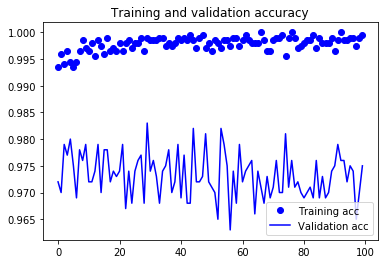

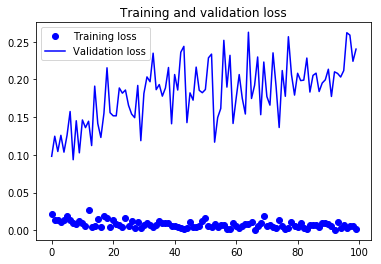

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()